In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [11]:
benign_img_dir = '../data/ISIC/benign/images'
malignant_img_dir = '../data/ISIC/malignant/images'
benign_mask_dir = '../data/ISIC/benign/segmentation'
malignant_mask_dir = '../data/ISIC/malignant/segmentation'
img_size = (96,128)

In [3]:
X_benign = np.array(tuple([np.array(Image.open(os.path.join(benign_img_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(benign_img_dir))]))
X_malignant = np.array(tuple([np.array(Image.open(os.path.join(malignant_img_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(malignant_img_dir))]))
X = np.concatenate((X_benign,X_malignant),axis=0)

100%|██████████| 2000/2000 [01:59<00:00, 11.13it/s] 


In [15]:
X_benign_mask = np.array(tuple([np.array(Image.open(os.path.join(benign_mask_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(benign_mask_dir))]))
X_malignant_mask = np.array(tuple([np.array(Image.open(os.path.join(malignant_mask_dir,x)).resize(reversed(img_size))) for x in tqdm(os.listdir(malignant_mask_dir))]))
X_mask = np.concatenate((X_benign_mask,X_malignant_mask),axis=0)

100%|██████████| 2000/2000 [00:28<00:00, 41.23it/s] 


In [16]:
y = np.concatenate((np.zeros(len(X_benign)),np.ones(len(X_malignant))),axis=0)

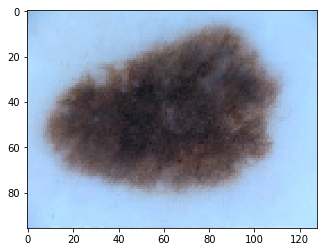

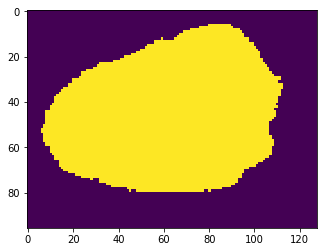

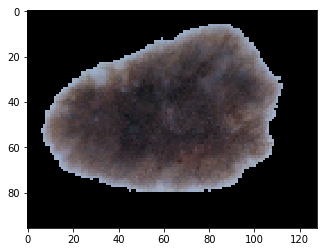

In [25]:
plt.imshow(X[0])
plt.show()

plt.imshow(X_mask[0]==255)
plt.show()

plt.imshow(X[0]*np.stack((X_mask[0]==255,X_mask[0]==255,X_mask[0]==255),axis=2))
plt.show()

In [26]:
X = X*np.stack((X_mask==255,X_mask==255,X_mask==255),axis=3)

In [27]:
X_mean, X_std = (np.mean(X,axis=(0,1,2)),np.std(X,axis=(0,1,2)))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                   test_size = 0.2, 
                                   random_state = 2018)

In [29]:
X_train_s = X_train.copy()
X_test_s = X_test.copy()
for i in range(3):
    X_train_s[:,:,:,i] = (X_train[:,:,:,i] - X_mean[i])/X_std[i]
    X_test_s[:,:,:,i] = (X_test[:,:,:,i] - X_mean[i])/X_std[i]

In [30]:
gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, shear_range=0.1, zoom_range=0.1, rotation_range=45)

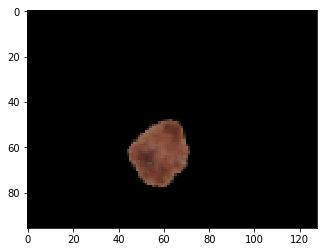

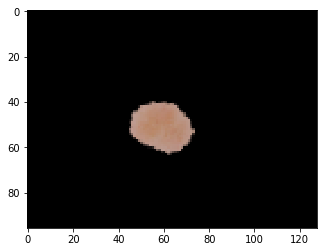

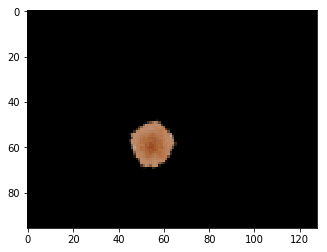

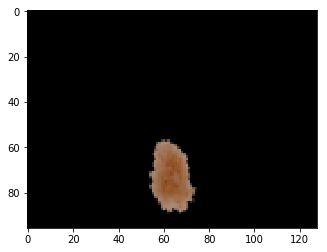

In [31]:
samples,_ = gen.flow(X_train,y_train, batch_size=4)[0]
for i in range(4):
    plt.imshow(samples[i]/255)
    plt.show()

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(*img_size,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 96, 128, 64)       1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 64, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 32, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 32, 256)       295168    
__________

In [37]:
model.compile('sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(restore_best_weights = True, patience = 3),
            keras.callbacks.ModelCheckpoint('../models/keras_model.h5',save_best_only=True),
            TQDMNotebookCallback()]

In [38]:
batch_size = 128

In [39]:
history = model.fit_generator(
    gen.flow(X_train_s,y_train, batch_size=batch_size),epochs=20,
    callbacks = callbacks,
    validation_data=(X_test_s,y_test),
    workers=6,
    steps_per_epoch = len(X_train)//batch_size,
    verbose=0)

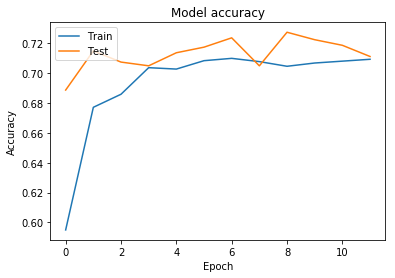

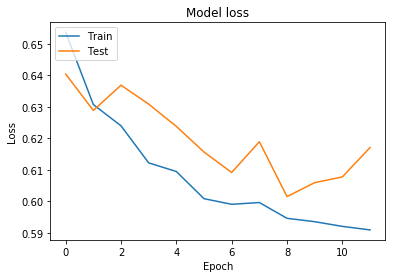

In [40]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
pd.DataFrame(history.history)

,val_loss,val_acc,loss,acc
0,0.640429,0.68875,0.653711,0.595000
1,0.628896,0.71500,0.630745,0.677188
2,0.636906,0.70750,0.624008,0.685937
3,0.630884,0.70500,0.612239,0.703750
4,0.623818,0.71375,0.609491,0.702812
5,0.615675,0.71750,0.600869,0.708438
6,0.609193,0.72375,0.599082,0.710000
7,0.618942,0.70500,0.599645,0.707812
8,0.601528,0.72750,0.594635,0.704688
9,0.605960,0.72250,0.593562,0.706875


In [43]:
model = keras.models.load_model('../models/keras_model.h5')

In [44]:
y_pred = model.predict_classes(X_test_s)

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73       389
         1.0       0.75      0.71      0.73       411

   micro avg       0.73      0.73      0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



In [69]:
y_pred.sum()

28